## Interpretation of TF models trained on UniProtKB Coronaviridae S protein dataset for multiclass classification using Saliency Scores

In [13]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../..',
 '/home/grads/blessyantony/dev/git/zoon

In [111]:
from prediction.models.nlp import transformer
from src.utils import utils, nn_utils
from src.utils.nlp_utils.padding import Padding

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

In [84]:
label_groupings = {
                    "Pig": [ "Sus scrofa (Pig) [TaxID: 9823]" ],
                    "Human": [ "Homo sapiens (Human) [TaxID: 9606]" ],
                    "Wild turkey": [ "Meleagris gallopavo (Wild turkey) [TaxID: 9103]" ],
                    "Japanese pipistrelle": [ "Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]" ],
                    "Lesser bamboo bat": [ "Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]" ],
                    "Chicken": [ "Gallus gallus (Chicken) [TaxID: 9031]" ],
                    "Bovine": [ "Bos taurus (Bovine) [TaxID: 9913]" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}
idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}

train_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 8,
    "max_sequence_length": 1453,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}

test_sequence_settings =  train_sequence_settings.copy()
test_sequence_settings["batch_size"] = 1

label_settings = {
    "label_col": "virus_host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 1453,
    "loss": "CrossEntropyLoss",
    "with_convolution": False,
    "n_heads": 8,
    "depth": 6,
    "n_tokens": 27,
    "n_classes": 7,
    "n_epochs": 10,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024
}

### Load the datasets

In [82]:
from torch.utils.data import Dataset


class ProteinSequenceDataset(Dataset):
    def __init__(self, df, sequence_col, max_seq_len, truncate, label_col):
        super(ProteinSequenceDataset, self).__init__()
        self.sequence_col = sequence_col
        self.max_seq_len = max_seq_len
        self.label_col = label_col
        self.amino_acid_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                               'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                               'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                               'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                               'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                               'J': 26}
        self.data = df
        if truncate:
            self.data = self.truncate_dataset(df)

    def __len__(self) -> int:
        return self.data.shape[0]

    def truncate_dataset(self, df):
        # Truncating sequences to fixed length of sequence_max_length
        df[self.sequence_col] = df[self.sequence_col].apply(lambda x: x[0:self.max_seq_len])
        return df

    def get_labels(self):
        return self.data[self.label_col]

    def __getitem__(self, idx: int):
        # loc selects based on index in df
        # iloc selects based on integer location (0, 1, 2, ...)
        record = self.data.iloc[idx, :]
        sequence = record[self.sequence_col]
        label = record[self.label_col]

        sequence_vector = np.array([self.amino_acid_map[a] for a in sequence])
        label_vector = np.array([label])

        return torch.tensor(sequence_vector, 
                            device=nn_utils.get_device(), 
                            dtype=torch.float64), torch.tensor(label_vector, device=nn_utils.get_device())


In [85]:
def get_token_dataset_loader(df, sequence_settings, label_col):
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))

def load_dataset_with_df(df, sequence_settings):
    df = df[[sequence_settings["sequence_col"], label_settings["label_col"]]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")
    dataset_loader = get_token_dataset_loader(df, sequence_settings, label_settings["label_col"])
    return index_label_map, dataset_loader

def print_dataset_loader(dataset_loader):
    sequence, label = next(iter(dataset_loader))
    print(sequence.shape)
    print(sequence)
    print(label.shape)
    print(label)

In [73]:
uniprotkb_coronaviruses_df = pd.read_csv("/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/coronaviridae_top_7_hosts.csv")
uniprotkb_coronaviruses_df.head()

,id,seq,virus,seq_len,virus_host,binary_label
0,A3EX94,MTLLMCLLMSLLIFVRGCDSQFVDMSPASNTSECLESQVDAAAFSK...,Bat coronavirus HKU4 (BtCoV) (BtCoV/HKU4/2004),1352,Tylonycteris pachypus (Lesser bamboo bat) (Ves...,Not Human
1,A3EXD0,MIRSVLVLMCSLTFIGNLTRGQSVDMGHNGTGSCLDSQVQPDYFES...,Bat coronavirus HKU5 (BtCoV) (BtCoV/HKU5/2004),1352,Pipistrellus abramus (Japanese pipistrelle) (P...,Not Human
2,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human
3,P11223,MLVTPLLLVTLLCALCSAVLYDSSSYVYYYQSAFRPPSGWHLQGGA...,Avian infectious bronchitis virus (strain Beau...,1162,Gallus gallus (Chicken) [TaxID: 9031],Not Human
4,P12651,MLVTPLLLVTLLCVLCSAALYDSSSYVYYYQSAFRPPNGWHLHGGA...,Avian infectious bronchitis virus (strain M41)...,1162,Gallus gallus (Chicken) [TaxID: 9031],Not Human


In [74]:
uniprotkb_coronaviruses_df["virus_host"].value_counts()

Sus scrofa (Pig) [TaxID: 9823]                                                                  2620
Homo sapiens (Human) [TaxID: 9606]                                                              2400
Meleagris gallopavo (Wild turkey) [TaxID: 9103]                                                   36
Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]      19
Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]                  17
Gallus gallus (Chicken) [TaxID: 9031]                                                             13
Bos taurus (Bovine) [TaxID: 9913]                                                                 10
Name: virus_host, dtype: int64

In [75]:
uniprotkb_coronaviruses_humans_df = uniprotkb_coronaviruses_df[uniprotkb_coronaviruses_df["virus_host"] == "Homo sapiens (Human) [TaxID: 9606]"]
print(uniprotkb_coronaviruses_humans_df.shape)
uniprotkb_coronaviruses_humans_df.head()

(2400, 6)


,id,seq,virus,seq_len,virus_host,binary_label
2,P0DTC2,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,Severe acute respiratory syndrome coronavirus ...,1273,Homo sapiens (Human) [TaxID: 9606],Human
5,P15423,MFVLLVAYALLHIAGCQTTNGLNTSYSVCNGCVGYSENVFAVESGG...,Human coronavirus 229E (HCoV-229E),1173,Homo sapiens (Human) [TaxID: 9606],Human
12,P36334,MFLILLISLPTAFAVIGDLKCTSDNINDKDTGPPPISTDTVDVTNG...,Human coronavirus OC43 (HCoV-OC43),1353,Homo sapiens (Human) [TaxID: 9606],Human
14,Q0ZME7,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N5) (HCoV-HKU1),1351,Homo sapiens (Human) [TaxID: 9606],Human
15,Q14EB0,MFLIIFILPTTLAVIGDFNCTNSFINDYNKTIPRISEDVVDVSLGL...,Human coronavirus HKU1 (isolate N2) (HCoV-HKU1),1351,Homo sapiens (Human) [TaxID: 9606],Human


min seq len = 35
max seq len = 1366


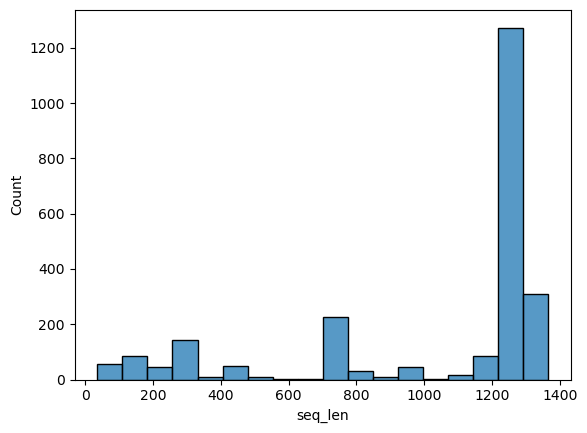

In [76]:
sns.histplot(uniprotkb_coronaviruses_humans_df["seq_len"])
print(f"min seq len = {min(uniprotkb_coronaviruses_humans_df['seq_len'])}")
print(f"max seq len = {max(uniprotkb_coronaviruses_humans_df['seq_len'])}")
plt.show()

In [86]:
index_label_map, coronavirus_dataset_loader = load_dataset_with_df(uniprotkb_coronaviruses_humans_df, test_sequence_settings)
print_dataset_loader(coronavirus_dataset_loader)
# Random seq, label from coronavirus_dataset_loader
coronavirus_seq, coronavirus_label = next(iter(coronavirus_dataset_loader))

Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
[2]
torch.Size([1, 1453])
tensor([[14.,  2., 17.,  ...,  0.,  0.,  0.]], device='cuda:0',
       dtype=torch.float64)
torch.Size([1])
tensor([2], device='cuda:0')


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/interpretation/../../../src/utils/utils.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/tmp/ipykernel_26483/845779479.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

### Load the trained model

##### Model: TF trained on Coronaviridae S protein dataset
#### Model: TF - PosEmb_SINCOS - MSL_1024 - d_512
#### Training Dataset: UniProtKB Coronaviridae 5K
#### Manual Seed = 0

In [22]:
model_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20230813/host_multi_baseline_focal/transformer-l_6-h_8_itr0.pth"
nlp_model_coronaviridae = transformer.get_transformer_model(model)
nlp_model_coronaviridae.load_state_dict(torch.load(model_path))
nlp_model_coronaviridae = nlp_model_coronaviridae.to(nn_utils.get_device())


Transformer(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(27, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
  (linear): Linear(in_features=512, out_features=7, b

In [113]:
class TransformerModel(nn.Module):
    def __init__(self, n_tokens, max_seq_len, n_classes, N=6, input_dim=512, hidden_dim=1024, h=8):
        super(Transformer, self).__init__()
        self.embedding = EmbeddingLayer(vocab_size=n_tokens, max_seq_len=max_seq_len, dim=input_dim)


        encoder_layers = TransformerEncoderLayer(d_model=input_dim, nhead=h, d_hid=hidden_dim, dropout=0.0, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, N, batch_first=True)

        self.linear = nn.Linear(input_dim, n_classes)
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.1
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, X):
        X = self.embedding(X)
        X = self.transformer_encoder(X, src_mask=None)
        # pool the embeddings of all tokens using mean
        X = X.mean(dim=1)

        y = self.linear(X)
        return y

### Prediction Performance

In [23]:
def validate(model, dataset_loader):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # tensorboard + logs

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df["y_true"] = labels.cpu().numpy()
            results.append(result_df)
    
    return pd.concat(results, ignore_index=True)

In [25]:
results = validate(nlp_model_coronaviridae, coronavirus_dataset_loader)

In [30]:
index_label_map

{0: 'Bovine',
 1: 'Chicken',
 2: 'Human',
 3: 'Japanese pipistrelle',
 4: 'Lesser bamboo bat',
 5: 'Pig',
 6: 'Wild turkey'}

In [34]:
results_df = results.rename(columns=index_label_map)
results_df["y_true"] = results_df["y_true"].map(lambda x: index_label_map[x])
results_df

,Bovine,Chicken,Human,Japanese pipistrelle,Lesser bamboo bat,Pig,Wild turkey,y_true
0,0.009269,0.003829,0.909964,0.002700,0.020296,0.000029,0.053912,Human
1,0.009764,0.003731,0.909157,0.002866,0.021172,0.000030,0.053281,Human
2,0.003933,0.363466,0.250910,0.002976,0.006701,0.300310,0.071703,Human
3,0.009451,0.003829,0.909095,0.002748,0.020634,0.000029,0.054213,Human
4,0.006680,0.004134,0.917927,0.001995,0.015391,0.000027,0.053846,Human
...,...,...,...,...,...,...,...,...
2395,0.003224,0.393320,0.252757,0.002440,0.005823,0.263034,0.079401,Human
2396,0.017362,0.005303,0.844665,0.004939,0.036343,0.000037,0.091352,Human
2397,0.046468,0.011549,0.591894,0.013795,0.090605,0.000068,0.245622,Human
2398,0.006362,0.004318,0.916721,0.001909,0.014835,0.000027,0.055828,Human


In [36]:
auprcs = []
for i in index_label_map.values():
    precision, recall, _ = precision_recall_curve(y_true=results_df["y_true"].values, probas_pred=results_df[i].values, pos_label=i)
    auprc = auc(recall, precision)
    print(f"AUPRC for class {i} = {auprc}")
    auprcs.append(auprc)

macro_auprc = mean(auprcs)
print(f"Macro AUPRC = {macro_auprc}")

AUPRC for class Bovine = 0.5
AUPRC for class Chicken = 0.5
AUPRC for class Human = 1.0
AUPRC for class Japanese pipistrelle = 0.5
AUPRC for class Lesser bamboo bat = 0.5
AUPRC for class Pig = 0.5
AUPRC for class Wild turkey = 0.5
Macro AUPRC = 0.5714285714285714


/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No posit

In [88]:
rbd_positions = [332,333,334,335,337,339,340,344,345,346,347,348,349,351,352,354,356,359,362,364,366,367,370,371,372,373,375,376,378,380,381,382,384,385,388,389,390,393,394,395,396,397,399,401,402,403,404,405,406,407,410,411,412,413,414,415,417,418,419,420,424,425,426,427,428,430,431,432,433,434,435,436,437,438,439,440,441,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,489,490,491,493,494,495,496,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,522,524]
rbm_positions = range(438, 506)

### Saliency Scores: Gradient Based

In [105]:
# Random seq, label from coronavirus_dataset_loader
coronavirus_seq, coronavirus_label = next(iter(coronavirus_dataset_loader))

In [106]:
coronavirus_seq.requires_grad = True
coronavirus_seq.retain_grad=True
# forward pass to calculate predictions
prediction = nlp_model_coronaviridae(coronavirus_seq)

In [107]:
print(prediction.shape)
prediction

torch.Size([1, 7])


tensor([[ 2.0022, -3.9619, -0.2079,  1.8773,  1.9596, -0.3123, -3.7544]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [108]:
# get index of class with highest prediction score
max_pred_score, max_pred_index = torch.max(prediction, dim=1)
print(f"max_pred_score = {max_pred_score}, max_pred_index={max_pred_index}")

max_pred_score = tensor([2.0022], device='cuda:0', grad_fn=<MaxBackward0>), max_pred_index=tensor([0], device='cuda:0')


In [109]:
# backward pass on the maximum prediction score to get gradients of score predicted class w.r.t. input image

max_pred_score.backward()

In [110]:
print(coronavirus_seq.grad)

None
